# Curso de Manejo de Datos Faltantes: Imputación

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [2]:
%run ../handling_missing_data/utils/pandas-missing-extension.py

## Configurar el aspecto general de las gráficas del proyecto

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [4]:
airquality_df = (
    sm.datasets.get_rdataset('airquality')
    .data
    .clean_names(
        case_type = 'snake'
    )
    .add_column('year',1973)
    .assign(
        date = lambda df: pd.to_datetime(df[['year','month','day']])
    )
    .sort_values(by = 'date')
    .set_index('date')
)
airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
# temp ~ ozone
(
    smf.ols(
        formula= 'temp ~ ozone',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Thu, 24 Nov 2022",Prob (F-statistic):,2.93e-18
Time:,14:40:59,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
# temp ~ ozone + solar_r
(
    smf.ols(
        formula= 'temp ~ ozone + solar_r',
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Thu, 24 Nov 2022",Prob (F-statistic):,1.47e-16
Time:,14:40:59,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


Vemos que en el dataset original teníamos 153 observaciones, luego cuando medimos la temperatura contra el ozono se redujo a 116 observaciones y cuando medimos el modelo de temperatura con las variables ozono y solar_r el número se redujo a 111 observaciones

Por lo tanto, al crear los modelos perdimos observaciones, dificultando la comparación entre distintos modelos, ya que cada modelo se está ajustando a una cantidad distinta de datos.

Esto se debe a que los algoritmos descartan los valores faltantes.

### Reto: Datos de supervivientes

In [7]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [8]:
(
    smf.ols(
        formula= "creatinine ~ chapter",
        data=survival_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,creatinine,R-squared:,0.069
Model:,OLS,Adj. R-squared:,0.061
Method:,Least Squares,F-statistic:,9.560
Date:,"Thu, 24 Nov 2022",Prob (F-statistic):,3.93e-22
Time:,14:41:00,Log-Likelihood:,-1673.6
No. Observations:,1962,AIC:,3379.
Df Residuals:,1946,BIC:,3469.
Df Model:,15,,
Covariance Type:,nonrobust,,


## Preparando datos: _National Health and Nutrition Examination Survey_

/home/mazzaroli/personalProjects/DataScience/basico/handing_missing_data/handling_missing_data/handling_missing_data/utils/pandas-missing-extension.py:279: UserWarning: registration of accessor <class '__main__.Visualization'> under name 'viz' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class Visualization:


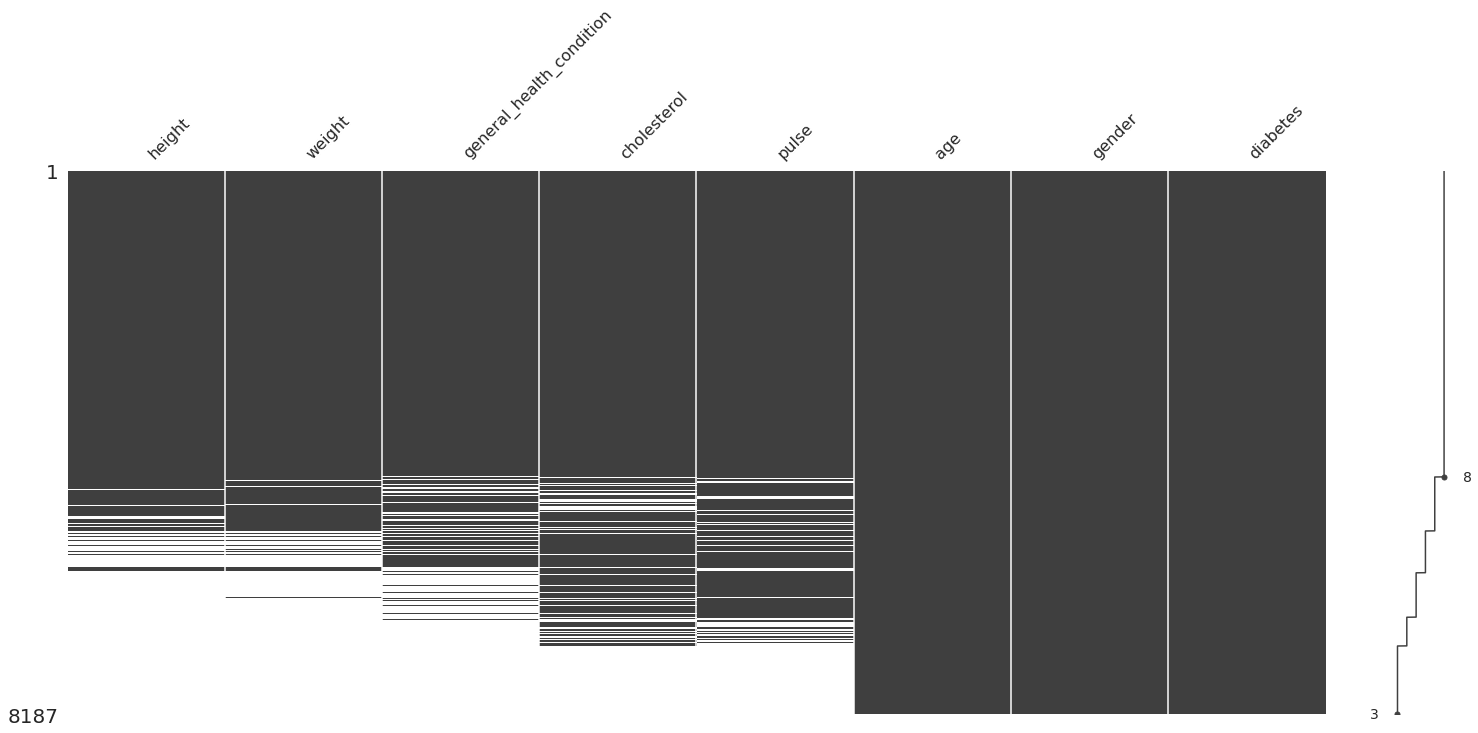

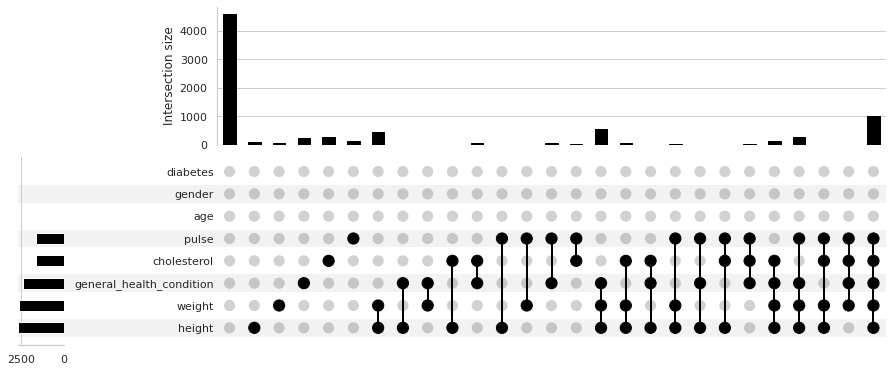

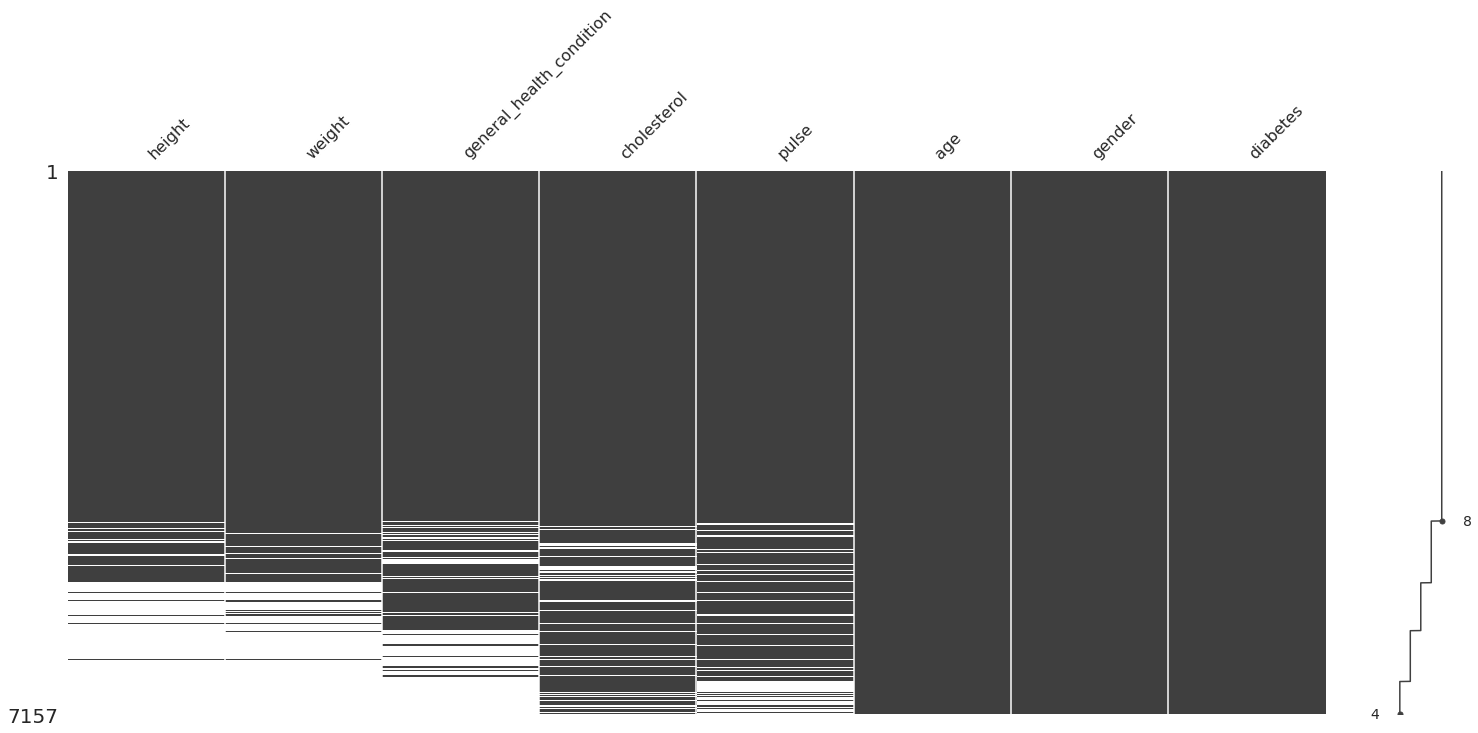

In [9]:
%run 0.0-download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes
<img src='missing_data_action.jpeg' width=600> 

### MCAR

La localización de los valores faltantes en el conjunto de datos ocurren completamente al azar, estos no dependen de ningún otro dato

**Eliminación de valores faltantes**
- Reducción del tamaño de muestra.
- Inferencia limitada.
- No produce sesgos

**Imputación de valores faltantes**
- De hacerlo bien, no produce sesgos
- La imputación es recomendada sobre la deleción.

### MAR

La localización de los valores faltantes en el conjunto de datos dependen de otros valores observados.

**Eliminación de valores faltantes**
- Ignorarlos produce sesgos

**Imputación de valores faltantes**
- La mayor parte de **métodos** de imputación asumen MAR
- La imputación es necesaria

### MNAR

La localización de los valores faltantes en el conjunto de datos dependen de otros valores faltantes en sí mismos.

**Eliminación de valores faltantes**
- Ignorarlos produce sesgos

**Imputación de valores faltantes**
- La imputación es recomendada sobre la deleción.

> 💡 Mejorar experimentos o realizar análisis de sensibilidad (repetir los experimentos, explorar los parámetros, ver como cambian los análisis al modificar algunos datos y establecer intervalos de confianza)

## MCAR: Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>Define la hipótesis alternativa. Las siguientes opciones están disponibles (la opción predeterminada es "dos caras")</p>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

**Hipótesis:**

Analizando los valores del peso ¿Existe alguna diferencia entre la ausencia o presencia de valores faltantes entre mujeres y hombres?

**Hipótesis nula ($h_0$)**:\
Si el $pvalue > 0.5$ no se rechaza la hipótesis nula

**Hipótesis alternativa ($h_1$)**:\
Si el $pvalue < 0.5$ se rechaza la hipótesis nula

In [10]:
female_weight, male_weight =(
    nhanes_df
    .select_columns('gender','weight')
    .transform_column(
        'weight',
        lambda x: x.isna(),
        elementwise= False
    )
    .groupby('gender')
    .weight
    .pipe(
        lambda df: (
            df.get_group('Female'),
            df.get_group('Male')
        )
    )
)

scipy.stats.ttest_ind(
    a=female_weight,
    b=male_weight,
    alternative='two-sided'
    )

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

El $pvalue$ es igual a $0.7$

Concluimos que los datos del peso entre hombres y mujeres, no están perdidos al azar.

## Amplía tu conjunto de herramientas para explorar valores faltantes

Explorar relación de variables categóricas en cuestión de ausencia de otra variable

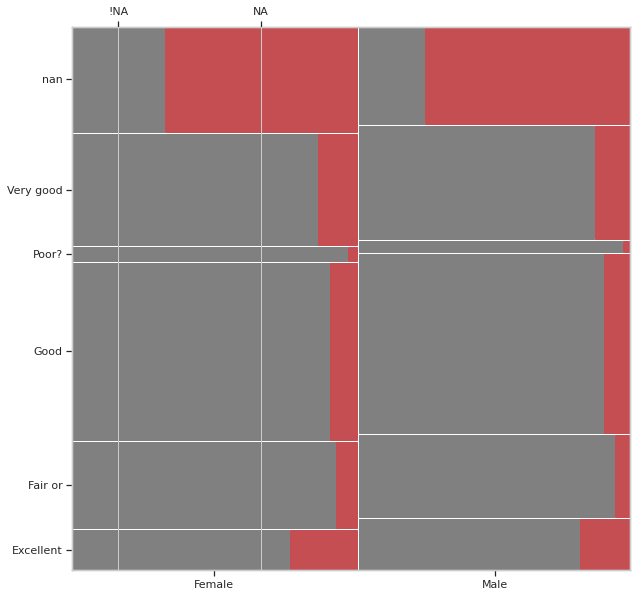

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

(
    nhanes_df.select_columns("weight", "general_health_condition", "gender")
    .assign(weight=lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"]))
    .groupby(
        ["gender", "general_health_condition", "weight"], dropna=False, as_index=True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data=df,
            properties=lambda key: {"color": "r" if "NA" in key else "gray"},
            ax=ax,
            horizontal=True,
            axes_label=True,
            title="",
            labelizer=lambda key: "",
        )
    )
)

ax.grid(False)

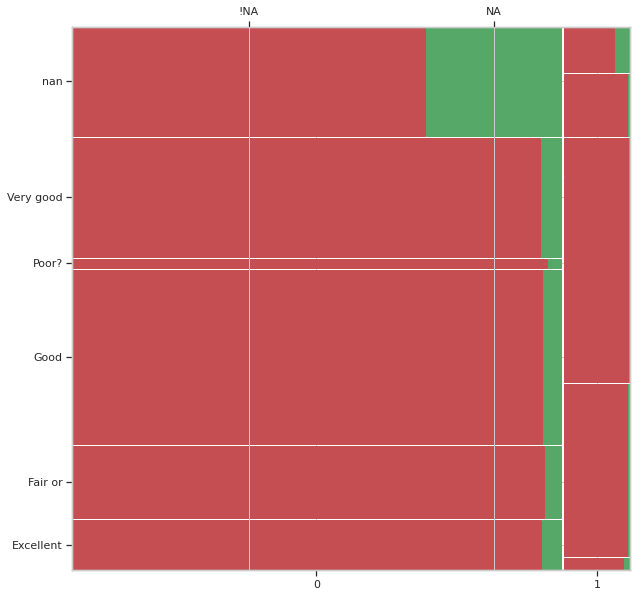

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
nhanes_df.missing.missing_mosaic_plot(target_var='pulse',x_categorical_var='diabetes',y_categorical_var='general_health_condition',ax=ax);

## Tratamiento de variables categóricas para imputación de valores faltantes

In [13]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [14]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [ ["Male"], ['Female'], ['Female']]
X

[['Male'], ['Female'], ['Female']]

In [15]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

Una vez ajustamos y transformamos nuestros datos con codificador, podemos hacer uso de su atributo encoder.categories_ para obtener las categorías únicas de nuestro conjunto de datos.

In [16]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [17]:
encoder.inverse_transform([[1],[0],[0],[1]])

array([['Male'],
       ['Female'],
       ['Female'],
       ['Male']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [18]:
categorical_columns =  nhanes_df.select_dtypes(include=[object, 'category']).columns

¿Cuál es el papel de la función **sklearn.compose.make_column_transformer()**?

Transformar cada columna con un transformador asociado a esta y guardar la información necesaria para realizar el procesamiento inverso.

In [19]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrough'
)

In [20]:
# Varias Categorias
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )    
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
)

nhanes_transformed_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,13.0,0.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,33.0,0.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,42.0,0.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0


In [21]:
# nhanes_transformed_df = nhanes_df.copy(deep=True)

# label_encoder = sklearn.preprocessing.LabelEncoder()

# encoder_gender = label_encoder.fit_transform(nhanes_transformed_df.gender)
# nhanes_transformed_df.gender = encoder_gender

# nhanes_transformed_df

### _One Hot Encoding_

**¿Qué es la codificación one-hot encoding?**

Convertirá cada valor categórico en una nueva columna categórica y le asignará un valor binario de 1 o 0 a esas columnas.

**¿Cuándo utilizarías una codificación one-hot en lugar de una codificación ordinal?**

Cuando mis variables categóricas no tienen un orden natural.

In [22]:
nhanes_transformed_df2 = nhanes_df.copy(deep=True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [23]:
(
    nhanes_transformed_df2
    .select_columns('general_health_condition')
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `skelearn.preprocessing.OneHotEncoder()`

**¿Cuál es una ventaja de realizar one-hot encoding utilizando sklearn en lugar de Pandas?**

Realizar one-hot encoding puede llegar a ser más robusto debido a que guarda la información necesaria de las categorías involucradas e incluye una forma de realizar transformaciones inversas.

In [24]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ['gender']),
    (sklearn.preprocessing.OneHotEncoder(), ['general_health_condition']),
    remainder = 'passthrough'
) 

In [25]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index=nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix('ordinalencoder__')
    )    
    .rename_columns(
        function = lambda x: x.removeprefix('remainder__')
    )
    .rename_columns(
        function = lambda x: x.removeprefix('onehotencoder__')
    )
)

nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,13.0,0.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,56.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,33.0,0.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,42.0,0.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0


In [26]:
print(
    (
        transformer
        .named_transformers_ 
        .get('ordinalencoder')
        .categories_
    ),
    (
        transformer
        .named_transformers_ 
        .get('onehotencoder')
        .categories_
    ),
    sep='\n'

)

[array(['Female', 'Male'], dtype=object)]
[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
      dtype=object)]


In [27]:
(
    transformer
    .named_transformers_ 
    .get('onehotencoder')
    .inverse_transform(
        X=[[0,0,0,1,0,0]]
    )
)

array([['Poor?']], dtype=object)

## Tipos de imputación de valores faltantes

<img src='imputation_methods.png' width=550>

La imputacion de valores faltantes trata de estimar los valores ausentes con base en los valores válidos de otras variables y/o casos de muestra (mano con el corazon) o modelos (cerebro).

### Imputaciones por donantes:

Completa los valores que faltan para una unidad dada copiando los valores observados de otra unidad, el donante.

### Imputaciones por modelos:

El objetivo de la imputacion bsada en modelo ese encontrar un modelo predictivo para cada variable objetivo en el conjunto de datos que contiene valores faltantes.

### Imputación por interpolación: 

Se estiman los valores perdidos interpolando (uniendo de manera lineal, polinomial, etc.) el último valor válido antes del valor perdido y el primer valor válido después del valor perdido.

## Imputación de un único valor (media, mediana, moda)

### Ventajas
- Rapido y facil.
- La media puede ser util en presencia de outliners
- No afectara el estadistico en cuestion ni el tamano de meustra.

### Desventajas
- Puede segar los resultados, dado que modifica la distribucion por debajo (curtosis)
- Pierde correlaicones entre variables. No es muy preciso 
- No puede usar variables categoricas (a excepcion en la moda)

In [28]:
(
    nhanes_df
    .transform_column(
        'height',
        lambda x: x.fillna(x.mean()),
        elementwise=False
    )
    .height
    .mean()
)

66.25655976676525

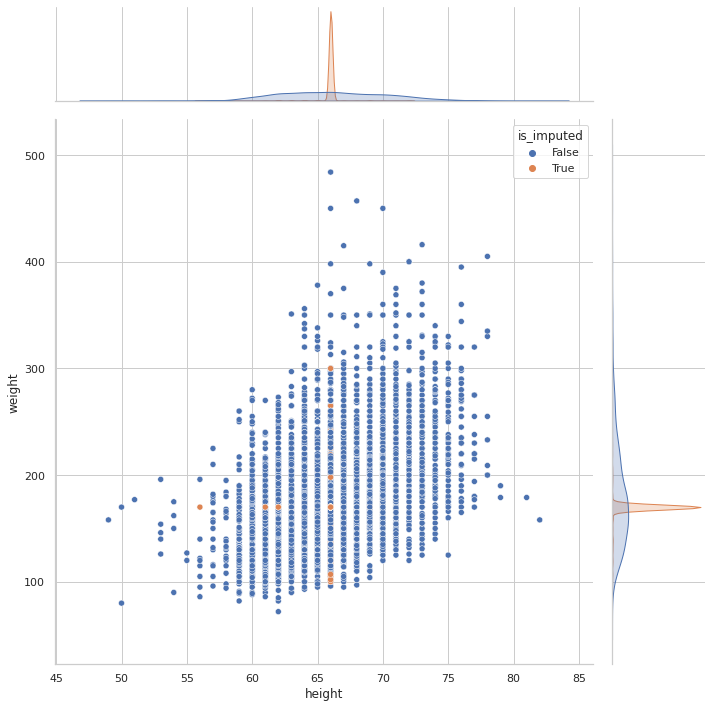

In [29]:
(
    nhanes_df
    .select_columns('height','weight')
    .missing.bind_shadow_matrix(True,False, suffix='_imp')
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight',
        show_marginal = True,
        height = 10
    )
);

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante (Hot deck imputation & Cold deck imputation)

### Ventajas

- Rápido y fácil
- Los datos imputados no son constantes.
- Existen trucos para evitar romper las relaciones entre variables

### Desventajas
 
- Relaciones multivariables pueden ser distorsionadas.

### `fillna()` vs `ffill()` o `bfill()`

In [30]:
(
    nhanes_df
    .select_columns('height','weight')
    # .fillna(method = 'bfill')
    .bfill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,62.0,200.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


In [31]:
(
    nhanes_df
    .select_columns('height','weight')
    # .fillna(method = 'ffill')
    .ffill()
)

,height,weight
SEQN,,
93705.0,63.0,165.0
93706.0,68.0,145.0
93707.0,68.0,145.0
93709.0,62.0,200.0
93711.0,69.0,142.0
...,...,...
102949.0,72.0,180.0
102953.0,65.0,218.0
102954.0,66.0,150.0


#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

In [32]:
(
    nhanes_df
    .select_columns('height','weight','gender','diabetes','general_health_condition')
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise=False
    )
)

,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94195.0,63.0,90.0,Female,0,Excellent
95793.0,61.0,96.0,Female,0,Excellent
101420.0,59.0,98.0,Female,0,Excellent
94148.0,65.0,100.0,Female,0,Excellent
102062.0,62.0,100.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96869.0,72.0,298.0,Male,1,NaN
97267.0,NaN,298.0,Male,1,NaN


In [33]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
    # .missing.proportion()
)


,height,weight,gender,diabetes,general_health_condition
SEQN,,,,,
94195.0,63.0,90.0,Female,0,Excellent
95793.0,61.0,96.0,Female,0,Excellent
101420.0,59.0,98.0,Female,0,Excellent
94148.0,65.0,100.0,Female,0,Excellent
102062.0,62.0,100.0,Female,0,Excellent
...,...,...,...,...,...
96561.0,74.0,290.0,Male,1,NaN
96869.0,72.0,298.0,Male,1,NaN
97267.0,72.0,298.0,Male,1,NaN


## Imputación por interpolación

### Ventajas
- Sencillo de implementar 
- Útil para **series de tiempo**
- Variabilidad de opciones al alcance

### Desventajas
- Puede romper relaciones entre variables
- Puede introducir valores fuera de rango

<AxesSubplot:xlabel='date'>

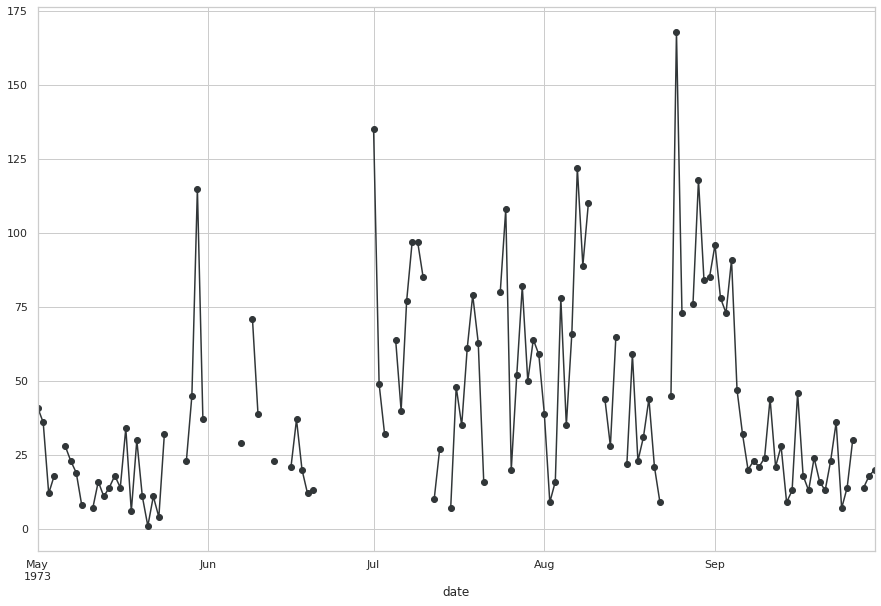

In [34]:
plt.figure(figsize=(15,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.plot(color='#313638', marker='o')
        )
    )
)

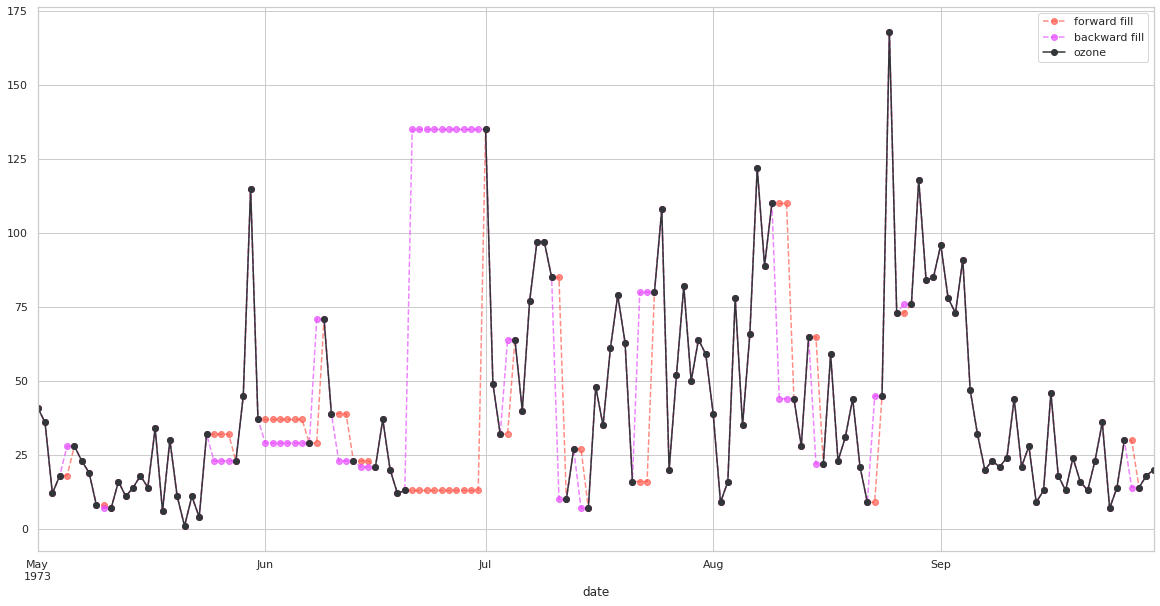

In [35]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.ffill().plot(color='#ff5447',marker='o',alpha=6/9,linestyle='dashed'),
            df.ozone.bfill().plot(color='#e647ff',marker='o',alpha=6/9,linestyle='dashed'),
            df.ozone.plot(color='#313638', marker='o')
        )
    )
)
plt.legend(['forward fill','backward fill','ozone'])


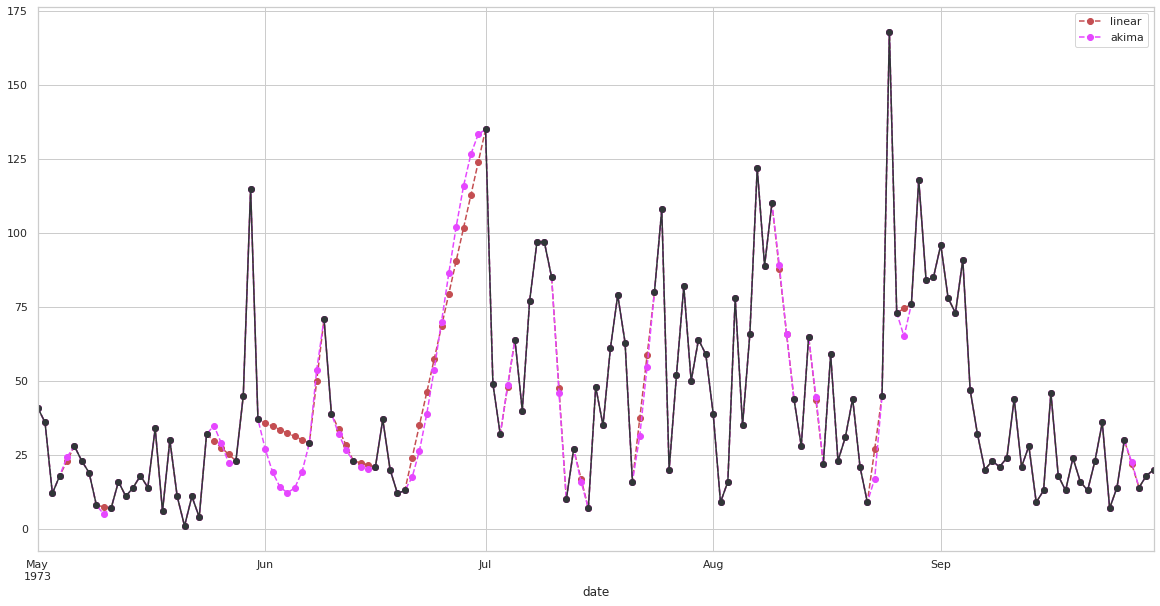

In [36]:
plt.figure(figsize=(20,10))
(
    airquality_df
    .select_columns('ozone')
    .pipe(
        lambda df: (
            df.ozone.interpolate(method='linear').plot(color='r',marker='o',linestyle='dashed'),
            df.ozone.interpolate(method='akima').plot(color='#e647ff',marker='o',linestyle='dashed'),
            df.ozone.plot(color='#313638', marker='o')
        )
    )
);
plt.legend([
'linear',
'akima',
]);

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Pasos para imputación por **K**-**N**earest-**N**eighbors
1. Encuentra otras **K** observaciones (donadores, vecinos) que sean más similares a esa observación.
1. Remplaza los valores faltantes con los valores agregados de los **K** vecinos.

### ¿Como determinar cuáles son los vecinos más similares?

A través de métricas de distancia

#### Cuantificación de distancia:

##### Distancia Euclidiana
Útil para variables numéricas.

##### Distancia Manhattan
Útil para variables tipo factor. 

>lunes, martes, rápido, lento, etc.

##### Distancia de Hamming
Útil para variables categóricas.

>Hola mundo\
>**Ho**j**a** **m**as**do**

##### Distancia de Gower
Útil para conjuntos de datos con variables mixtas

>Variables numéricas + Variables tipo factor + Variables categóricas = Distancia de Gower

### Ventajas
- Sencillo de implementar.
- Buen rendimiento con conjuntos de datos pequeños.
- Excelente para datos numéricos, pero también funciona para datos mixtos.
### Desventajas
- Su estabilidad puede ser comprometedora
- Requiere transformaciones especiales para las variables categóricas.
- Posee sensibilidad a valores atípicos

[Documentacion](https://scikit-learn.org/stable/modules/neighbors.html)

In [37]:
nhanes_df

,height,weight,general_health_condition,cholesterol,pulse,age,gender,diabetes
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,66.0,Female,0
93706.0,68.0,145.0,Very good,148.0,82.0,18.0,Male,0
93707.0,NaN,NaN,Good,189.0,100.0,13.0,Male,0
93709.0,62.0,200.0,NaN,176.0,74.0,75.0,Female,0
93711.0,69.0,142.0,Very good,238.0,62.0,56.0,Male,0
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,33.0,Male,0
102953.0,65.0,218.0,Fair or,182.0,78.0,42.0,Male,0
102954.0,66.0,150.0,Good,172.0,78.0,41.0,Female,0


In [38]:
nhanes_transformed_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,13.0,0.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,33.0,0.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,42.0,0.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0


In [39]:
knn_inputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep=True)

nhanes_df_knn.iloc[:,:] = knn_inputer.fit_transform(nhanes_transformed_df).round()

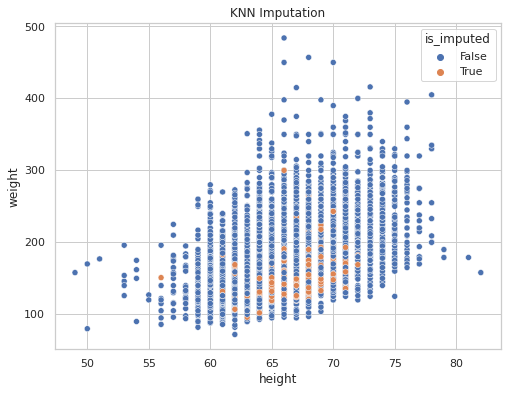

In [40]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True,False,suffix='_imp',only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight'
    )
);
plt.title('KNN Imputation');

### Ordenamiento por cantidad de variables faltantes

In [41]:
knn_inputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

nhanes_df_knn.iloc[:,:] = knn_inputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending=True)).round()


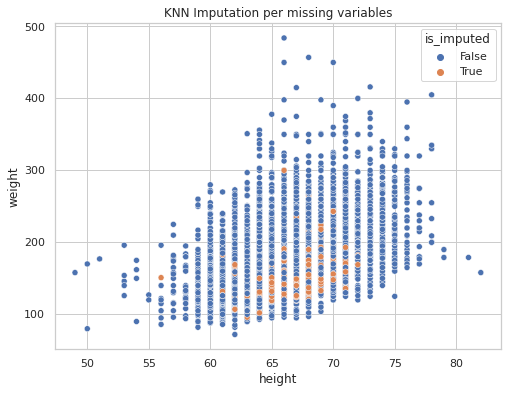

In [42]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True,False,suffix='_imp',only_missing=True)
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(
        x='height',
        y='weight'
    )
);
plt.title('KNN Imputation per missing variables');

## Imputación basada en modelos

### Ventajas
- Mejora sobre la imputacion basada en donante sencilla.
- Gran variedad de opciones para imputar (SVM, Neural Networks, Random Forest, regresiones, Etc)
- Preservacion de relaciones entre variables.
### Desventajas
- Puede subestimar la varianza.
- Los modelos funcionan mal si las variables observadas y faltantes son independientes
- Mas complicado que la imputacion basada en donantes

In [83]:
nhanes_model_df = (
    nhanes_df
    .select_columns('height', 'weight','gender', 'age',)
    .sort_values(by='height',ascending=True)
    .transform_column(
        'weight',
        lambda x: x.ffill(),
        elementwise=False
    )
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix='_imp',
        only_missing=False
    )
)

nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,NaN,107.0,Female,14.0,True,False,False,False
102926.0,NaN,107.0,Female,15.0,True,False,False,False
102941.0,NaN,107.0,Female,14.0,True,False,False,False


In [84]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols(
            formula="height ~ weight + gender + age", 
            data=df
        )
        .fit()
    )
)

In [85]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [86]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ['height']] = ols_imputed_values

In [95]:
nhanes_model_df

,height,weight,gender,age,height_imp,weight_imp,gender_imp,age_imp
SEQN,,,,,,,,
94940.0,49.0,158.0,Female,80.0,False,False,False,False
96508.0,50.0,170.0,Female,46.0,False,False,False,False
97877.0,50.0,80.0,Female,29.0,False,False,False,False
102379.0,51.0,177.0,Female,71.0,False,False,False,False
93816.0,53.0,146.0,Female,80.0,False,False,False,False
...,...,...,...,...,...,...,...,...
102915.0,63.0,107.0,Female,14.0,True,False,False,False
102926.0,63.0,107.0,Female,15.0,True,False,False,False
102941.0,63.0,107.0,Female,14.0,True,False,False,False


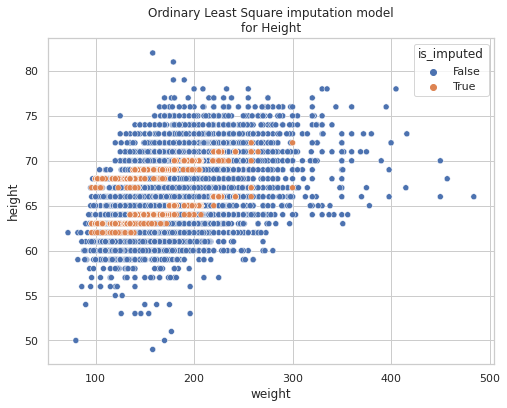

In [96]:
(
    nhanes_model_df
    .missing
    .scatter_imputation_plot(
        x='weight',
        y='height'
    )
)
plt.title('Ordinary Least Square imputation model\nfor Height');


## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)
Multiple Imputation Chained Equations

<img src='https://www.researchgate.net/publication/44203418/figure/fig1/AS:668969979625472@1536506280174/Main-steps-used-in-multiple-imputation.png' width=600>

### Ventajas
- Mantiene la distribucion relativa similar antes y despues de la imputacion.
- Puede ser utilziada en cualquier tipo de analisis (**MCAR**, **MAR** o analisis de sensibilidad con valores tipo **MNAR**).
- Multiple variables son imputadas.
### Desventajas
- Para funcionar bien necesitas pensar en el modelo de imputación y el modelo de análisis.
- Solo funciona como los metodos de imputacion seleccionados.

In [139]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator=BayesianRidge(),
    initial_strategy='mean',
    imputation_order='ascending',
)

nhanes_mice_df = nhanes_transformed_df.copy(deep=True)

nhanes_mice_df.iloc[:,:] = mice_imputer.fit_transform(nhanes_transformed_df).round()
nhanes_mice_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0
93707.0,2.0,1.0,70.0,200.0,189.0,100.0,13.0,0.0
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,75.0,0.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,33.0,0.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,42.0,0.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0


In [140]:
nhanes_mice_df = pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=True)
    ],
    axis = 1
)
nhanes_mice_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes,height_imp,weight_imp,general_health_condition_imp,cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,66.0,0.0,False,False,False,False,False
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,18.0,0.0,False,False,False,False,False
93707.0,2.0,1.0,70.0,200.0,189.0,100.0,13.0,0.0,True,True,False,False,False
93709.0,2.0,0.0,62.0,200.0,176.0,74.0,75.0,0.0,False,False,True,False,False
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,56.0,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,33.0,0.0,False,False,False,False,False
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,42.0,0.0,False,False,False,False,False
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,41.0,0.0,False,False,False,False,False


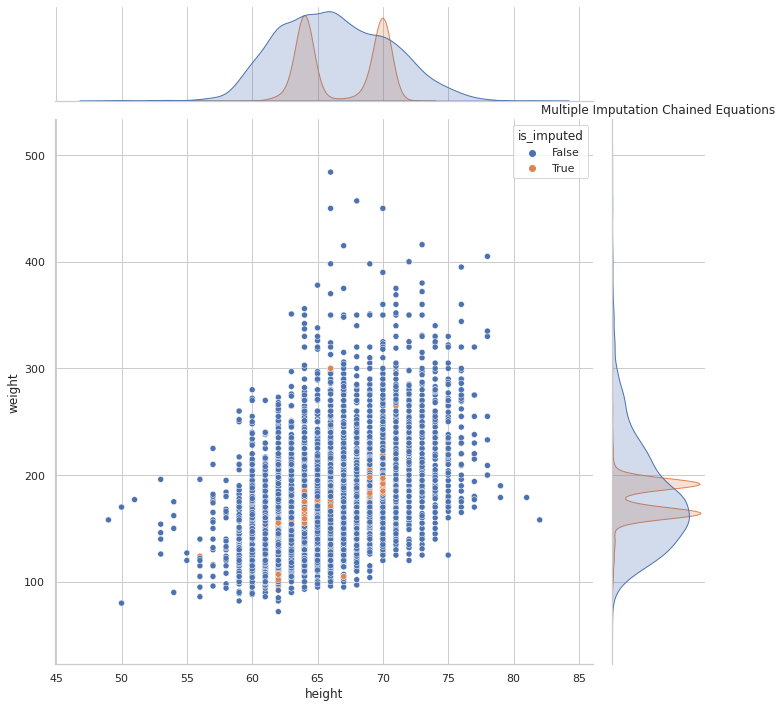

In [141]:
nhanes_mice_df.missing.scatter_imputation_plot(
    x = "height",
    y = "weight",
    show_marginal=True,
    height=10
);
plt.title('Multiple Imputation Chained Equations');

[MICE algorithm to Impute missing values in a dataset](https://www.numpyninja.com/post/mice-algorithm-to-impute-missing-values-in-a-dataset)

## Transformación inversa de los datos

In [145]:
nhanes_imputed_df = nhanes_mice_df.copy(deep=True)

In [153]:
nhanes_imputed_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X=nhanes_mice_df[categorical_columns]
    )
)
nhanes_imputed_df

,general_health_condition,gender,height,weight,cholesterol,pulse,age,diabetes,height_imp,weight_imp,general_health_condition_imp,cholesterol_imp,pulse_imp
SEQN,,,,,,,,,,,,,
93705.0,Good,Female,63.0,165.0,157.0,52.0,66.0,0.0,False,False,False,False,False
93706.0,Very good,Male,68.0,145.0,148.0,82.0,18.0,0.0,False,False,False,False,False
93707.0,Good,Male,70.0,200.0,189.0,100.0,13.0,0.0,True,True,False,False,False
93709.0,Good,Female,62.0,200.0,176.0,74.0,75.0,0.0,False,False,True,False,False
93711.0,Very good,Male,69.0,142.0,238.0,62.0,56.0,0.0,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,Excellent,Male,72.0,180.0,201.0,96.0,33.0,0.0,False,False,False,False,False
102953.0,Fair or,Male,65.0,218.0,182.0,78.0,42.0,0.0,False,False,False,False,False
102954.0,Good,Female,66.0,150.0,172.0,78.0,41.0,0.0,False,False,False,False,False


In [167]:
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [161]:
nhanes_imputed_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [164]:
nhanes_df.missing.number_missing()

5812

In [163]:
nhanes_imputed_df.missing.number_missing()

0

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    </p>
</div>

## Información de sesión

In [168]:
session_info.show()